# Model Building

In [69]:
import statsmodels.api as sm
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [15]:
#importing csv files from previous notebooks

yelp_fs_citybike_df = pd.read_csv(r'../data\yelp_fs_citybike_df.csv')
unique_ven_by_stn = pd.read_csv(r'../data\unique_venue_by_station.csv')

## Creating the different dataframes that I used for my models

In [20]:
#creating a df with the average distance of the venues to the bike station.

average_distance_by_area = unique_ven_by_stn.groupby('Station Id')['Distance (m)'].mean()
average_distance_by_stn = pd.DataFrame({
    'Station Id': average_distance_by_area.index,
    'Average Distance (m)': average_distance_by_area.values})

In [21]:
average_distance_by_stn = average_distance_by_stn.merge(unique_ven_by_stn[['Station Id', 'Number of Bikes']],
    on='Station Id', how='left')

In [22]:
average_distance_by_stn = average_distance_by_stn.groupby('Station Id').head(1)
average_distance_by_stn.head(1)

,Station Id,Average Distance (m),Number of Bikes
0,7000,638.421951,6


In [127]:
#Dealing with nans in the unique_ven_by_stn df

unique_ven_by_stn_nn = unique_ven_by_stn.drop(columns=['Price 1-4'])
unique_ven_by_stn_nn=unique_ven_by_stn_nn.dropna(subset=['Rating %'])
unique_ven_by_stn_nn.head(1)

,Name,Category,Distance (m),Rating %,Station Id,Station Name,Number of Bikes
0,Gusto 101,Italian,673.3,80.0,7000,Fort York Blvd / Capreol Ct,6


In [27]:
#Creating Average Rating column

average_rating_by_area = unique_ven_by_stn_nn.groupby('Station Id')['Rating %'].mean()
rating_by_area = pd.DataFrame({
    'Station Id': average_rating_by_area.index,
    'Average Rating %': average_rating_by_area.values})

In [28]:
rating_by_area = rating_by_area.merge(unique_ven_by_stn_nn[['Station Id', 'Station Name', 'Number of Bikes']],
    on='Station Id', how='left')
rating_by_area = rating_by_area.groupby('Station Id').head(1)

In [31]:
#creating df with both average distance and average ratings

average_rating_distance = pd.merge(rating_by_area, average_distance_by_stn, on='Station Id')

columns_drop = ['Number of Bikes_y']
average_rating_distance = average_rating_distance.drop(columns_drop, axis=1)

In [128]:
average_rating_distance.columns = ['Station Id','Average Rating %', 'Station Name', 'Number of Bikes', 'Average Distance (m)']
average_rating_distance.head(1)

,Station Id,Average Rating %,Station Name,Number of Bikes,Average Distance (m)
0,7000,81.5,Fort York Blvd / Capreol Ct,6,638.421951


### Build a regression model.

I created many models throughout this process. This first one was the most successful and the one I will be focussing my analysis on. The other models are included after as well, for interest.

**Multivariate - Number of Bikes to Distance and Rating**

In [35]:
#correlation matrix
average_rating_distance.corr(numeric_only = True)

,Station Id,Average Rating %,Number of Bikes,Average Distance (m)
Station Id,1.000000,-0.428604,-0.089310,0.173002
Average Rating %,-0.428604,1.000000,0.149959,-0.181359
Number of Bikes,-0.089310,0.149959,1.000000,-0.126602
Average Distance (m),0.173002,-0.181359,-0.126602,1.000000


The correlation matrix gives a number between -1 and 1 to indicate where the variables relationships lie. There is a strong negative correlation (-1) a strong positive correlation (1)  or no correlation (0) and the varying degrees in between.

The numbers we are interested in are between the number of bikes and the average rating and average distance.

Average rating and the number of bikes is approximately 0.15. This indicates a weak positive correlation and that stations near venues with a higher rating may have slightly more bikes.
Average distance and the number of bikes is approximately -0.13 indicating a weak negative correlation. Stations with a smaller average distances may have more bikes. However both correlations are very weak and likely irrelevant.

In [53]:
#pearson r testing

stat, p1 = scipy.stats.pearsonr(average_rating_distance['Average Distance (m)'], average_rating_distance['Number of Bikes'])
stat, p2 = scipy.stats.pearsonr(average_rating_distance['Average Rating %'], average_rating_distance['Number of Bikes'])
print(p2, p2)

7.767732039494585e-05 7.767732039494585e-05


The p-values for the pearson r tests for correlation are all very low and therefore indicate to reject the null hypothesis and suggests that there is a statistical correlation.

In [54]:
#model set up

y = average_rating_distance['Number of Bikes']
X = average_rating_distance[['Average Distance (m)', 'Average Rating %']]
X = sm.add_constant(X)
X.head()

,const,Average Distance (m),Average Rating %
0,1.0,638.421951,81.500000
1,1.0,447.858511,80.372340
2,1.0,617.600000,79.758621
3,1.0,614.282022,79.932584
4,1.0,560.757471,80.977011


In [55]:
model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     11.60
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           1.11e-05
Time:                        23:31:24   Log-Likelihood:                -2244.5
No. Observations:                 689   AIC:                             4495.
Df Residuals:                     686   BIC:                             4509.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0699 

Looking at the results for this model, I can see that the constants p-value is over 0.05 suggesting that it is not statistically significant. So I will run the model again without it.

This Breusch Pagan test was done on the results of this model with the constant as a constant is required for the Breusch Pagan test.

In [56]:
residuals = results.resid

In [57]:
#Breuschpagan test for homoscedasticity

stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,results.model.exog)
print(p,f_p)

0.0020333596956726907 0.0019748417775289563


Both p-values are below 0.05 showing that homoscedasticity is not present. 

In [58]:
#model set up with out constant

y = average_rating_distance['Number of Bikes']
X = average_rating_distance[['Average Distance (m)', 'Average Rating %']]
#X = sm.add_constant(X) running model again without the constant
X.head()

,Average Distance (m),Average Rating %
0,638.421951,81.500000
1,447.858511,80.372340
2,617.600000,79.758621
3,614.282022,79.932584
4,560.757471,80.977011


In [59]:
model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:        Number of Bikes   R-squared (uncentered):                   0.630
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              583.7
Date:                Wed, 30 Aug 2023   Prob (F-statistic):                   7.41e-149
Time:                        23:31:35   Log-Likelihood:                         -2244.6
No. Observations:                 689   AIC:                                      4493.
Df Residuals:                     687   BIC:                                      4502.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

#### Analysis

The regression results show my dependent variable in the upper left corner which is 'Number of Bikes'. 

The R-Squared and Adj R-Squared values are the highest I've obtained throughout all the models that I've attempted. The R-squared at 0.630 suggests that 63% of the variability in the number of bikes can be explained by the other variables. It is considered an uncentered value because I removed the constant after seeing its p-value in the first attempt.

The coefficient values indicate the prediction of how the variables will change with respect to each other. For example, with the coefficient of the average distance being negative, it implys that as the average distance increases, the number of bikes would decrease, and the positive average rating implies that as the average rating increases so does the number of bikes. This is in line with my original thought as people would be taking there bikes to areas with higher ratied venues. While the coefficients we got do fall in line with those examples, the numbers are so small that the affect is negligable.

The p-values for both the variables are < 0.05 and so are considered statistically significant.

While the R-squared numbers and p-values < 0.05 make this model appear to look promising for showing a connection between the average distance, and average rating to the number of bikes, the numbers surrounding the variable data is not strong enough to back that up. The following tests will show that the assumptions that should be made in order for this model to be more reliable have failed. Also the low Prob(Omnibus) and JB values in these results suggest that the data may not be normally distributed. I feel many of these findings could be in part to the limitations on the cellected data set. With a city like Toronto where everything is very centralized to the cities core, it makes it difficult to separate the patterns. Also, with the limitations on requesting data through the API for such a city with so many bike stations, the number of venues per bike station was also limited. This raises many questions about the completeness of the data, like how many venues per station are there in total? what categories of venues were missed when getting data? Would the breakdown of venue categories be different if the dataset was complete? Having a more complete and reliable data set may have allowed for a more confident conclusion.

#### Checking Assumpions

Text(0.5, 1.0, 'Number of Bikes vs. Average Rating %')

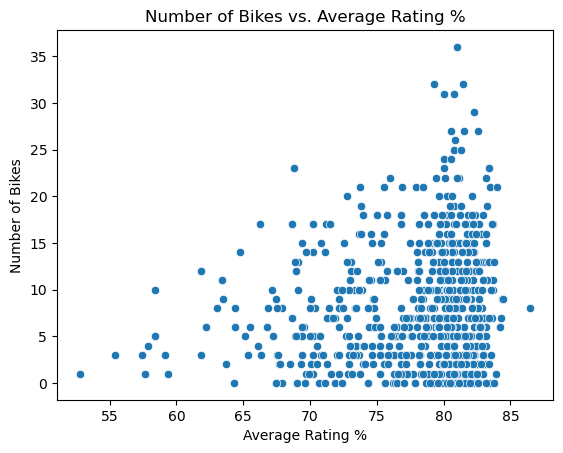

In [60]:
#scatterplot for number of bikes and rating

sp1 = sns.scatterplot(x=average_rating_distance['Average Rating %'], y=average_rating_distance['Number of Bikes'])
sp1.set_title('Number of Bikes vs. Average Rating %')

Text(0.5, 1.0, 'Number of Bikes vs. Average Distance (m)')

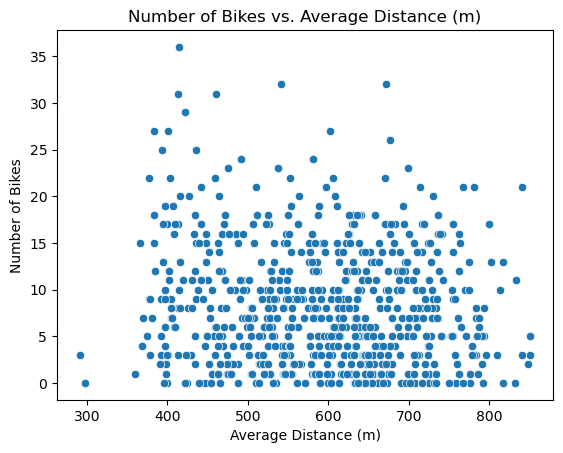

In [61]:
#scatterplot for bumber of bikes and distance

sp1 = sns.scatterplot(x=average_rating_distance['Average Distance (m)'], y=average_rating_distance['Number of Bikes'])
sp1.set_title('Number of Bikes vs. Average Distance (m)')

Variables do not pass the linear assumption

<Axes: ylabel='Count'>

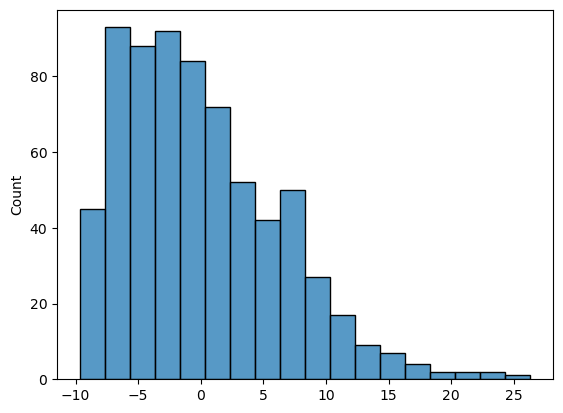

In [62]:
#checking normality assumption on the residuals.

residuals = results.resid
sns.histplot(residuals)

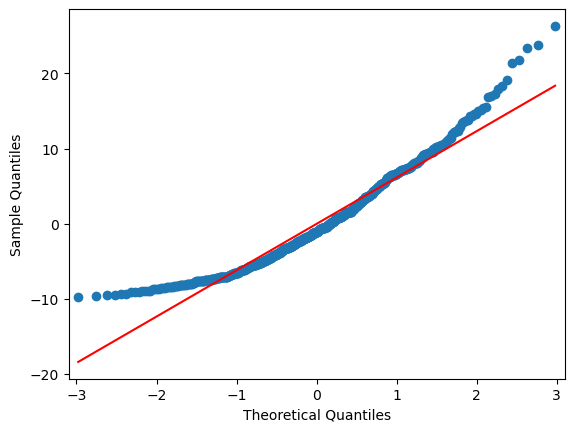

In [63]:
#QQ plot

sm.qqplot(residuals, line="r")
plt.show()

In [64]:
#Shapiro Wilks test for normal distribution

scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9460981488227844, pvalue=3.881899057707255e-15)

The very small p-value suggests that our data is not normally distributed, which we can also see in the above histogram and qq chart.

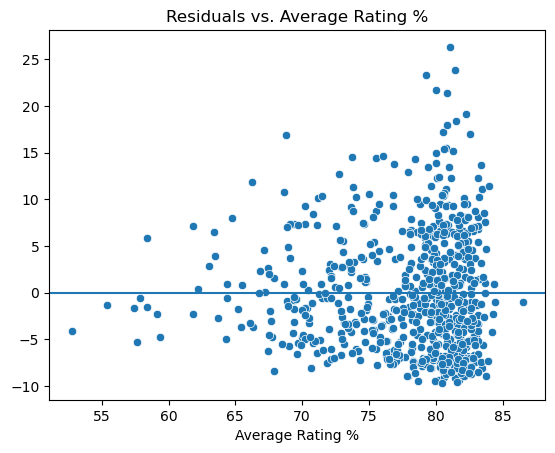

In [65]:
#checking assumption for homoscedasticity

ax = sns.scatterplot(x=average_rating_distance['Average Rating %'], y=residuals)
plt.title('Residuals vs. Average Rating %')
ax.axhline(0) #horizontal line at 0

Homoscedasticity is not present.

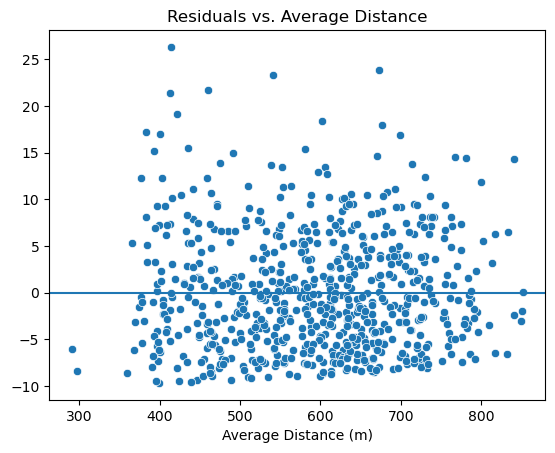

In [66]:
ax = sns.scatterplot(x=average_rating_distance['Average Distance (m)'], y=residuals)
plt.title('Residuals vs. Average Distance')
ax.axhline(0)

 Scaling the values in the data frame did not improve the model fit as seen below.

In [67]:
#creating df with only the numerical values for scaling

average_rating_distance_numeric = average_rating_distance[['Average Rating %', 'Average Distance (m)', 'Number of Bikes']]

In [70]:
# scaling

scaler = MinMaxScaler()
average_rating_distance_numeric_scaled = pd.DataFrame(scaler.fit_transform(average_rating_distance_numeric), columns=average_rating_distance_numeric.columns)

In [71]:
#model set up

y = average_rating_distance_numeric_scaled['Number of Bikes']
X = average_rating_distance_numeric_scaled[['Average Distance (m)', 'Average Rating %']]
X = sm.add_constant(X)
X.head()

,const,Average Distance (m),Average Rating %
0,1.0,0.620439,0.851852
1,1.0,0.280302,0.818440
2,1.0,0.583274,0.800255
3,1.0,0.577352,0.805410
4,1.0,0.481815,0.836356


In [72]:
#repeating the model with scaled data

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     11.60
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           1.11e-05
Time:                        23:32:48   Log-Likelihood:                 224.51
No. Observations:                 689   AIC:                            -443.0
Df Residuals:                     686   BIC:                            -429.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1608 

### Below are all of the other models I attempted throughout this process. Analysis are not included for them, but I thought I would include the work.

### Average Distance and Number of Bikes

In [73]:
average_distance_by_stn.corr(numeric_only = True)

,Station Id,Average Distance (m),Number of Bikes
Station Id,1.000000,0.173002,-0.089310
Average Distance (m),0.173002,1.000000,-0.126602
Number of Bikes,-0.089310,-0.126602,1.000000


In [74]:
#pearson r

stat, p = scipy.stats.pearsonr(average_distance_by_stn['Average Distance (m)'], average_distance_by_stn['Number of Bikes'])
p

0.0008668153236270769

p value < 0.05 suggest that we reject the null hypothesis, which is that there is no correlation. This implies that there is possible a correlation between the two. At this point.

In [75]:
# Regression Model set up

y = average_distance_by_stn['Number of Bikes']
X = average_distance_by_stn['Average Distance (m)']
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept (b value), bias
X.head()

,const,Average Distance (m)
0,1.0,638.421951
82,1.0,447.858511
176,1.0,617.600000
263,1.0,614.282022
352,1.0,560.757471


In [76]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     11.19
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           0.000867
Time:                        23:32:55   Log-Likelihood:                -2250.4
No. Observations:                 689   AIC:                             4505.
Df Residuals:                     687   BIC:                             4514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.3619 

In [77]:
residuals = results.resid

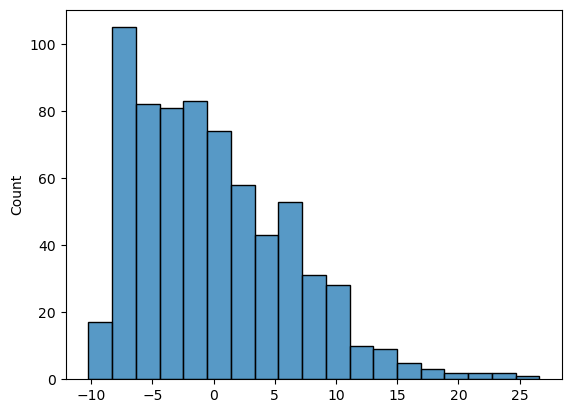

In [78]:
sns.histplot(residuals)
plt.show()

In [79]:
#shaprio wilks to see if the residuals are normally distributed

scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9406419992446899, pvalue=5.902958845129826e-16)

The low p-value suggest that the residuals are not normally distributed, as we can see in the histogram.

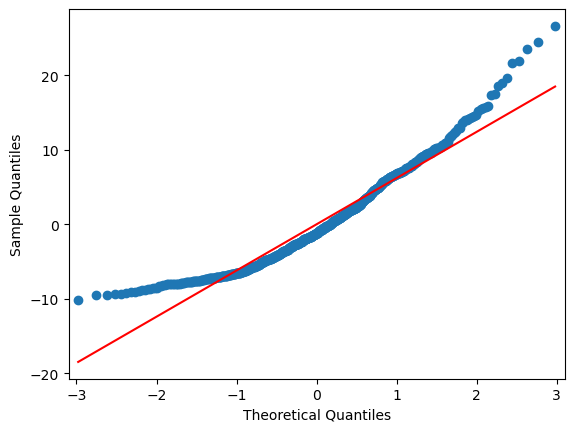

In [80]:
sm.qqplot(residuals, line="r")
plt.show()

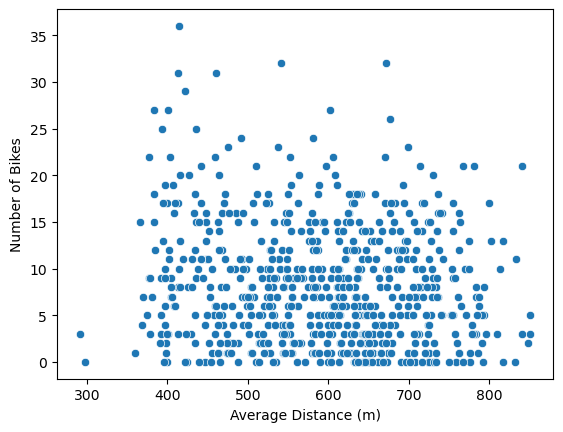

In [81]:
sns.scatterplot(data=average_distance_by_stn, x='Average Distance (m)', y='Number of Bikes')
plt.show()

### Average Distance and Number of Bikes with scaling

In [82]:
# scaling

scaler = MinMaxScaler()
average_distance_by_stn_scaled = pd.DataFrame(scaler.fit_transform(average_distance_by_stn), columns=average_distance_by_stn.columns)

In [83]:
#numbers are exactly the same after scaling

average_distance_by_stn_scaled.corr(numeric_only = True)

,Station Id,Average Distance (m),Number of Bikes
Station Id,1.000000,0.173002,-0.089310
Average Distance (m),0.173002,1.000000,-0.126602
Number of Bikes,-0.089310,-0.126602,1.000000


In [84]:
stat, p = scipy.stats.pearsonr(average_distance_by_stn_scaled['Average Distance (m)'], average_distance_by_stn_scaled['Number of Bikes'])
p

0.0008668153236270769

In [85]:
#model set up

y = average_distance_by_stn_scaled['Number of Bikes']
X = average_distance_by_stn_scaled['Average Distance (m)']
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept (b value), bias
X.head()

,const,Average Distance (m)
0,1.0,0.620439
1,1.0,0.280302
2,1.0,0.583274
3,1.0,0.577352
4,1.0,0.481815


In [86]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     11.19
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           0.000867
Time:                        23:33:06   Log-Likelihood:                 218.62
No. Observations:                 689   AIC:                            -433.2
Df Residuals:                     687   BIC:                            -424.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2854 

The numbers in the model after scaling are hardly worth mentioning. The biggest difference I noticed is in the coefficients and the Log-likelihood.

### Average Rating and Number of Bikes

In [87]:
unique_ven_by_stn.head(1)

,Name,Category,Distance (m),Rating %,Price 1-4,Station Id,Station Name,Number of Bikes
0,Gusto 101,Italian,673.3,80.0,2.0,7000,Fort York Blvd / Capreol Ct,6


In [88]:
rating_by_area.corr(numeric_only=True)

,Station Id,Average Rating %,Number of Bikes
Station Id,1.000000,-0.428604,-0.089310
Average Rating %,-0.428604,1.000000,0.149959
Number of Bikes,-0.089310,0.149959,1.000000


In [89]:
stat, p = scipy.stats.pearsonr(rating_by_area['Number of Bikes'], rating_by_area['Average Rating %'])
p

7.767732039494585e-05

In [90]:
#model set up

y = rating_by_area['Number of Bikes']
X = rating_by_area['Average Rating %']
X = sm.add_constant(X)
X.head()

,const,Average Rating %
0,1.0,81.500000
82,1.0,80.372340
176,1.0,79.758621
263,1.0,79.932584
352,1.0,80.977011


In [91]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.80
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           7.77e-05
Time:                        23:33:12   Log-Likelihood:                -2248.2
No. Observations:                 689   AIC:                             4500.
Df Residuals:                     687   BIC:                             4509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.3103      3.637  

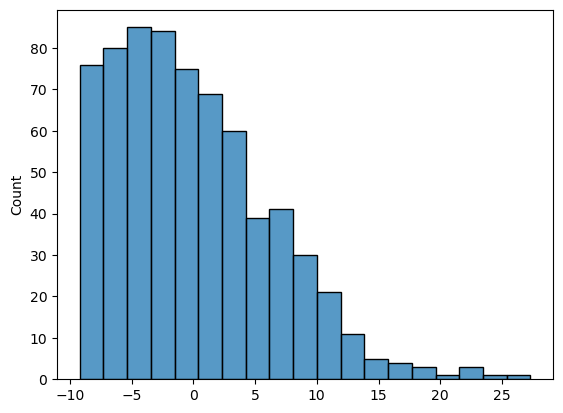

In [92]:
residuals = results.resid
sns.histplot(residuals)
plt.show()

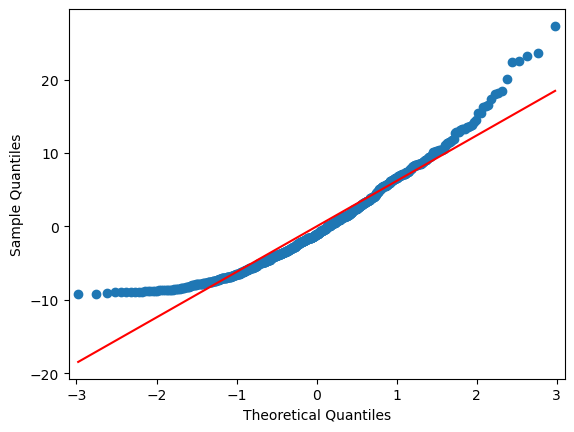

In [93]:
sm.qqplot(residuals, line="r")
plt.show()

In [94]:
import scipy
scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9450380206108093, pvalue=2.6651309350205323e-15)

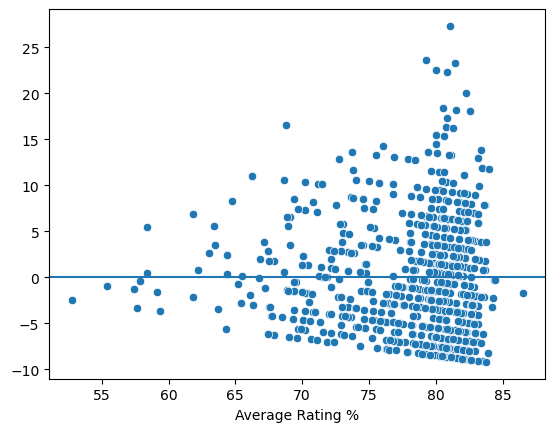

In [95]:
ax = sns.scatterplot(x=rating_by_area['Average Rating %'], y=residuals)
ax.axhline(0) #horizontal line at 0

In [96]:
#hypothesis test to check homoscedasticity breusch pagan

stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,results.model.exog)
print(p,f_p) #actually performs two tests, so it returns two p-value

0.0010256846007119574 0.0010006107762688345


Scaling

In [97]:
rating_by_area.head()

,Station Id,Average Rating %,Station Name,Number of Bikes
0,7000,81.500000,Fort York Blvd / Capreol Ct,6
82,7001,80.372340,Wellesley Station Green P,11
176,7002,79.758621,St. George St / Bloor St W,9
263,7003,79.932584,Madison Ave / Bloor St W,2
352,7004,80.977011,University Ave / Elm St,6


In [98]:
rating_by_area_numeric = rating_by_area[['Average Rating %', 'Number of Bikes']]
rating_by_area_numeric

,Average Rating %,Number of Bikes
0,81.500000,6
82,80.372340,11
176,79.758621,9
263,79.932584,2
352,80.977011,6
...,...,...
44553,81.318681,11
44644,82.108434,18
44727,76.779070,8
44813,77.040000,0


### Average Rating and Number of Bikes with completely unnecessary scaling

In [99]:
scaler = MinMaxScaler()
rating_by_area_scaled = pd.DataFrame(scaler.fit_transform(rating_by_area_numeric), columns=rating_by_area_numeric.columns)

In [100]:
rating_by_area_scaled.head()

,Average Rating %,Number of Bikes
0,0.851852,0.166667
1,0.818440,0.305556
2,0.800255,0.250000
3,0.805410,0.055556
4,0.836356,0.166667


In [101]:
rating_by_area_scaled.corr(numeric_only = True)

,Average Rating %,Number of Bikes
Average Rating %,1.000000,0.149959
Number of Bikes,0.149959,1.000000


In [102]:
stat, p = scipy.stats.pearsonr(rating_by_area_scaled['Average Rating %'], rating_by_area_scaled['Number of Bikes'])
p

7.767732039494585e-05

In [103]:
#model set up

y = rating_by_area_scaled['Number of Bikes']
X = rating_by_area_scaled['Average Rating %']
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept (b value), bias
X.head()

,const,Average Rating %
0,1.0,0.851852
1,1.0,0.818440
2,1.0,0.800255
3,1.0,0.805410
4,1.0,0.836356


In [104]:
model = sm.OLS(y, X) # called instantiating a model, making a class
results = model.fit() #.fit the model (this is where OLS is actually being run)

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.80
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           7.77e-05
Time:                        23:33:27   Log-Likelihood:                 220.89
No. Observations:                 689   AIC:                            -437.8
Df Residuals:                     687   BIC:                            -428.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0961      0.033  

### Number of Restaurants in the area/ Number of Bikes

In [105]:
yelp_fs_citybike_df.shape

(53974, 13)

In [106]:
#removing non-restaurant venues from df

cat_to_exclude = ['Cafes', 'Cafe' 'Coffee','Tea','Bakeries','Bakery','Libraries','Spas','Spa','Desserts','Lounges','Trucks', 'Breweries','Galleries','Salons','Arcades','Ice Cream', 'Frozen Yogurt','Caterers','Hair','Delivery','Grocery','Landmarks','Skin Care','Museums','Butcher','Cheese Shops','Venues','Juice Bars & Smoothies','Framing','Event Photography','Shops','Home','Shopping','Bowling','Art','Botanical Gardens','Virtual Reality','Beer', 'Wine & Spirits','Donuts','Bubble Tea','Stores','Art Supplies','Street Vendors','Nurseries & Gardening','Pool Halls','Massage','Schools','School','Waxing','Farmers Market','Clothing','Hookah Bars','Classes','Health','Go Karts','Parks','Park', 'Cooking Classes','Tennis','Food Stands International', 'Grocery', 'Church',  'Sporting', 'Organization', 'Store', 'Soccer']

df_restaurants = yelp_fs_citybike_df[~yelp_fs_citybike_df['Category'].str.contains('|'.join(cat_to_exclude))]

In [107]:
df_restaurants.head(1)

,Name,Category,Distance (m),Rating,Rating %,Number of Reviews,Price 1-4,Station Id,Station Name,Latitude,Longitude,Number of Bikes,Site
0,Gusto 101,Italian,673.3,4.0,80.0,1151.0,2.0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,6,yelp


In [108]:
number_of_restaurants = df_restaurants.groupby('Station Id')['Name'].count()
number_of_restaurants.head()

Station Id
7000    84
7001    84
7002    73
7003    75
7004    77
Name: Name, dtype: int64

In [109]:
restaurants_by_area = pd.DataFrame({
    'Station Id': number_of_restaurants.index,
    'Number of Restaurants': number_of_restaurants.values})

In [110]:
restaurants_by_area = restaurants_by_area.merge(df_restaurants[['Station Id', 'Station Name', 'Number of Bikes']],
    on='Station Id', how='left')

In [111]:
restaurants_by_area=restaurants_by_area.groupby('Station Id').head(1)
restaurants_by_area.head()

,Station Id,Number of Restaurants,Station Name,Number of Bikes
0,7000,84,Fort York Blvd / Capreol Ct,6
84,7001,84,Wellesley Station Green P,11
168,7002,73,St. George St / Bloor St W,9
241,7003,75,Madison Ave / Bloor St W,2
316,7004,77,University Ave / Elm St,6


In [112]:
restaurants_by_area.corr(numeric_only = True)

,Station Id,Number of Restaurants,Number of Bikes
Station Id,1.000000,-0.388007,-0.089310
Number of Restaurants,-0.388007,1.000000,0.148949
Number of Bikes,-0.089310,0.148949,1.000000


In [113]:
stat, p = scipy.stats.pearsonr(restaurants_by_area['Number of Restaurants'], restaurants_by_area['Number of Bikes'])
p

8.688869987340089e-05

In [114]:
y = restaurants_by_area['Number of Bikes']
X = restaurants_by_area['Number of Restaurants']
X = sm.add_constant(X)
X.head()

,const,Number of Restaurants
0,1.0,84
84,1.0,84
168,1.0,73
241,1.0,75
316,1.0,77


In [115]:
model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.59
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           8.69e-05
Time:                        23:33:35   Log-Likelihood:                -2248.3
No. Observations:                 689   AIC:                             4501.
Df Residuals:                     687   BIC:                             4510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.14

Scaled

In [116]:
restaurants_by_area_numeric =restaurants_by_area[['Number of Restaurants', 'Number of Bikes']]

### Number of not Restaurants

In [117]:
cat_to_keep = ['Cafes', 'Cafe' 'Coffee','Tea','Bakeries','Bakery','Libraries','Spas','Spa','Desserts','Lounges','Trucks', 'Breweries','Galleries','Salons','Arcades','Ice Cream', 'Frozen Yogurt','Caterers','Hair','Delivery','Grocery','Landmarks','Skin Care','Museums','Butcher','Cheese Shops','Venues','Juice Bars & Smoothies','Framing','Event Photography','Shops','Home','Shopping','Bowling','Art','Botanical Gardens','Virtual Reality','Beer', 'Wine & Spirits','Donuts','Bubble Tea','Stores','Art Supplies','Street Vendors','Nurseries & Gardening','Pool Halls','Massage','Schools','School','Waxing','Farmers Market','Clothing','Hookah Bars','Classes','Health','Go Karts','Parks','Park', 'Cooking Classes','Tennis','Food Stands International', 'Grocery', 'Church',  'Sporting', 'Organization', 'Store', 'Soccer']

df_not_restaurants = yelp_fs_citybike_df[yelp_fs_citybike_df['Category'].str.contains('|'.join(cat_to_keep))]

In [118]:
number_of_not_restaurants = df_not_restaurants.groupby('Station Id')['Name'].count()

In [119]:
not_restaurants_by_area = pd.DataFrame({
    'Station Id': number_of_not_restaurants.index,
    'Number of not Restaurants': number_of_not_restaurants.values})

In [120]:
non_restaurants_by_area = not_restaurants_by_area.merge(df_not_restaurants[['Station Id', 'Station Name', 'Number of Bikes']],
    on='Station Id', how='left')

In [121]:
non_restaurants_by_area=non_restaurants_by_area.groupby('Station Id').head(1)

In [122]:
non_restaurants_by_area.head()

,Station Id,Number of not Restaurants,Station Name,Number of Bikes
0,7000,9,Fort York Blvd / Capreol Ct,6
9,7001,16,Wellesley Station Green P,11
25,7002,22,St. George St / Bloor St W,9
47,7003,21,Madison Ave / Bloor St W,2
68,7004,17,University Ave / Elm St,6


In [123]:
non_restaurants_by_area.corr(numeric_only=True)

,Station Id,Number of not Restaurants,Number of Bikes
Station Id,1.000000,-0.081656,-0.089310
Number of not Restaurants,-0.081656,1.000000,-0.067524
Number of Bikes,-0.089310,-0.067524,1.000000


In [124]:
stat, p1 = scipy.stats.pearsonr(non_restaurants_by_area['Number of not Restaurants'], non_restaurants_by_area['Number of Bikes'])
p

8.688869987340089e-05

In [125]:
y = non_restaurants_by_area['Number of Bikes']
X = non_restaurants_by_area['Number of not Restaurants']
X = sm.add_constant(X)
X.head()

,const,Number of not Restaurants
0,1.0,9
9,1.0,16
25,1.0,22
47,1.0,21
68,1.0,17


In [126]:
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Number of Bikes   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.147
Date:                Wed, 30 Aug 2023   Prob (F-statistic):             0.0765
Time:                        23:33:42   Log-Likelihood:                -2254.4
No. Observations:                 689   AIC:                             4513.
Df Residuals:                     687   BIC:                             4522.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Stretch

#### How can you turn the regression model into a classification model?

You could turn the above regression problem into classification one by converting the numeric values into categorical ones. The number of bikes could be sorted into low, medium, or high capcities based on how many bicycles there are at the station at the time of data retrieval. There was also a differntiation in the CityBikes information between regular bikes and e-bikes, perhaps that could also be a route to follow.

Exploratory data analysis can still involve various visualization techniques like histograms and bar plots. For deeper analysis, hypothesis testing methods such as crosstab and Chi-square tests can be employed to assess the potential independence between variables. Additionally, T-tests or Paired T-tests can be used to compare means among two or more categories respectively.

Once the preliminary analysis is complete, you might progress to utilizing a logistic regression model. This model is used when your target variable is categorical and involves predicting the likelihood of a categorical outcome based on the characteristics of the data.